In [1]:
import pandas as pd
from collections import defaultdict
import json

/tmp/ipykernel_42652/2348510317.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv('./data/aug-cc-pvtz-data', header=None, names=['mol', 'angle', 'energy'], sep=' ')

In [3]:
energies_dict = defaultdict(dict)
for item in [25, 39, 50, 51, 53, 56, 58]:
    tmp_df = df[df['mol'] == item]
    energies_dict[str(item)] = {'angles':tmp_df['angle'].to_list(), 'final_energies':tmp_df['energy'].to_list()} 

In [4]:
import copy
import io
import json
from collections import defaultdict

import click
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
from matplotlib.backends.backend_pdf import PdfPages
from openff.toolkit.topology import Molecule
from PIL import Image
from simtk import unit
from tabulate import tabulate
from cinnabar.stats import bootstrap_statistic
from visualization import show_oemol_struc
import warnings
warnings.filterwarnings("ignore")

In [5]:
PARTICLE = unit.mole.create_unit(
    6.02214076e23 ** -1,
    "particle",
    "particle",
)
HARTREE_PER_PARTICLE = unit.hartree / PARTICLE
HARTREE_TO_KCALMOL = HARTREE_PER_PARTICLE.conversion_factor_to(
    unit.kilocalorie_per_mole
)
BOLTZMANN_CONSTANT = unit.constants.BOLTZMANN_CONSTANT_kB
REF_SPEC = 'mp2/heavy-aug-cc-pv[tq]z + d:ccsd(t)/heavy-aug-cc-pvdz'

In [6]:
def get_relative_energies(energies, conv_factor):
    min_energy = min(energies)
    energies = [conv_factor*(ener - min_energy) for ener in energies]
    return energies

In [7]:

KELLYS_COLORS = [
    "#ebce2b",
    "#db6917",
    "#96cde6",
    
]
pdf = PdfPages("./output/torsion_profiles_refs.pdf")
markers = ['D', 'P']

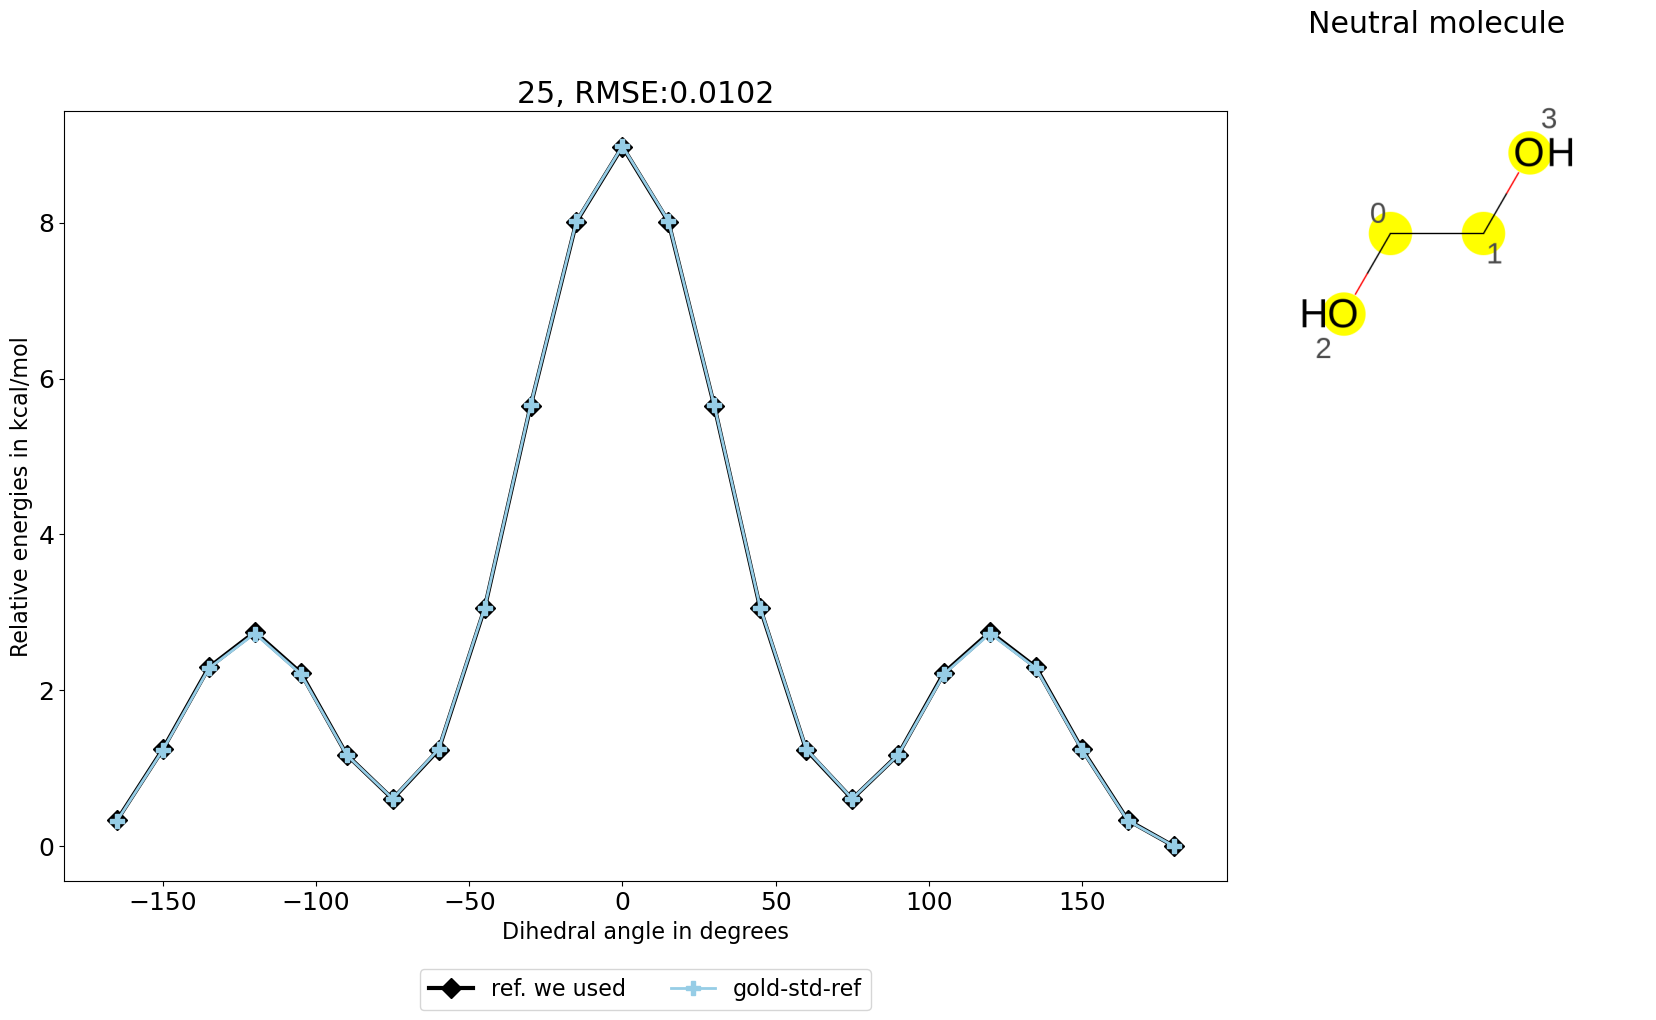

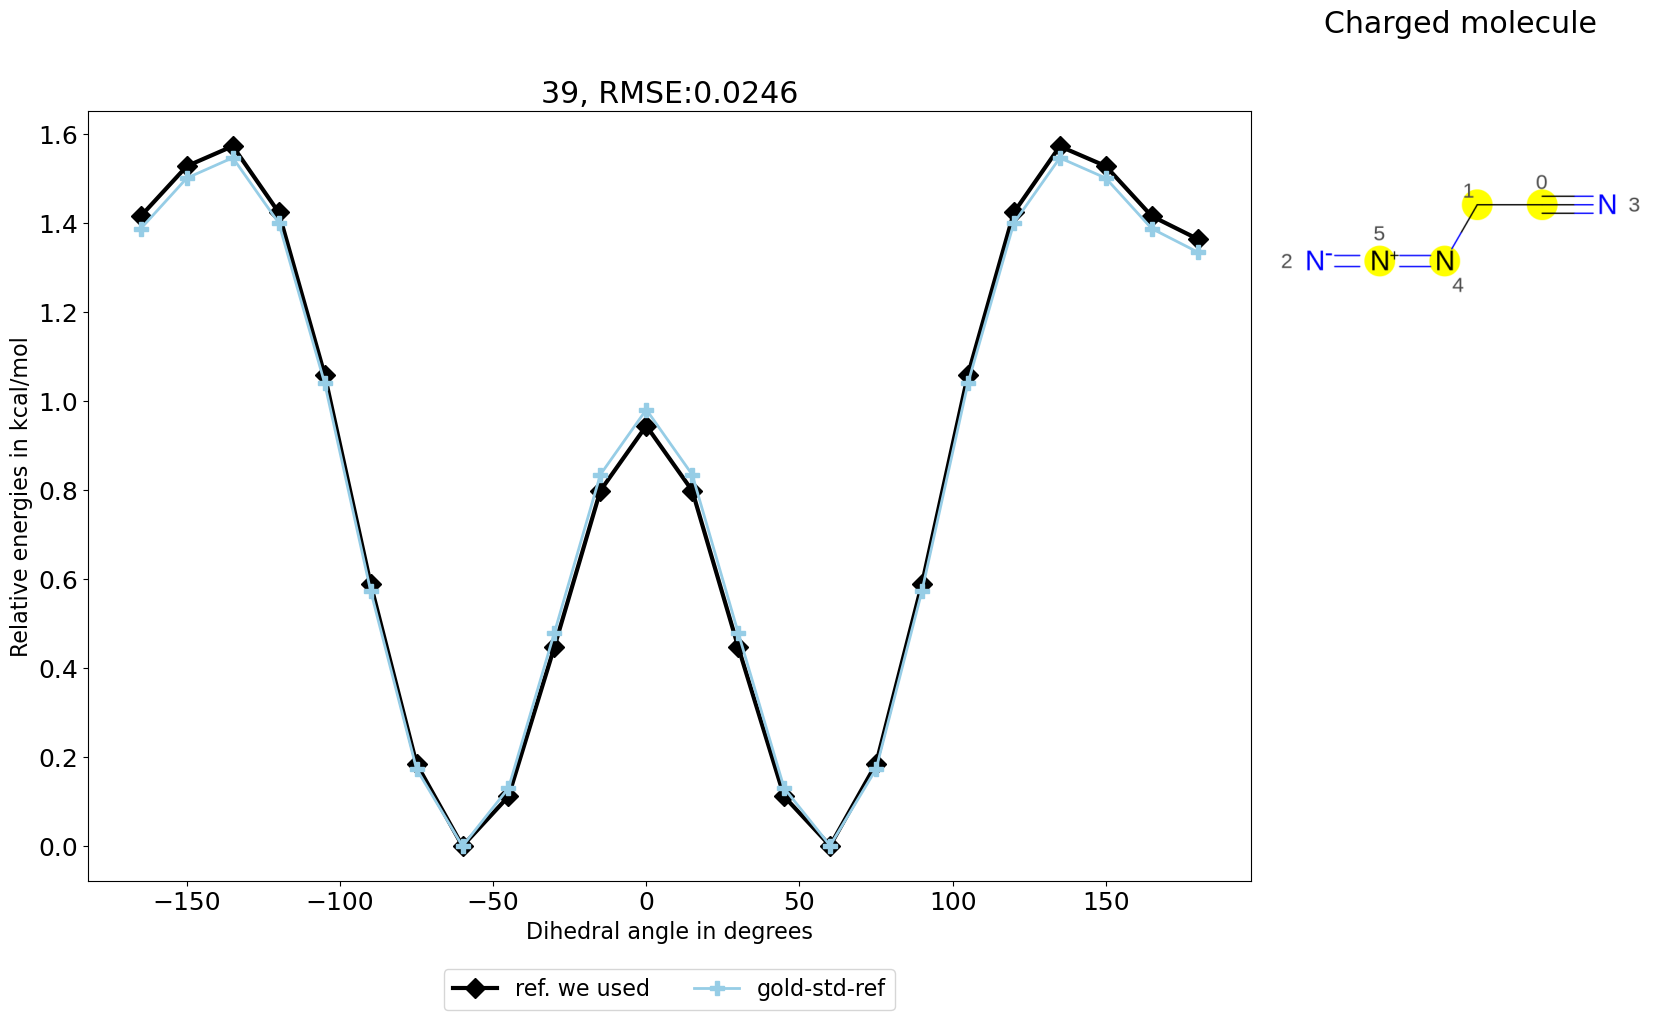

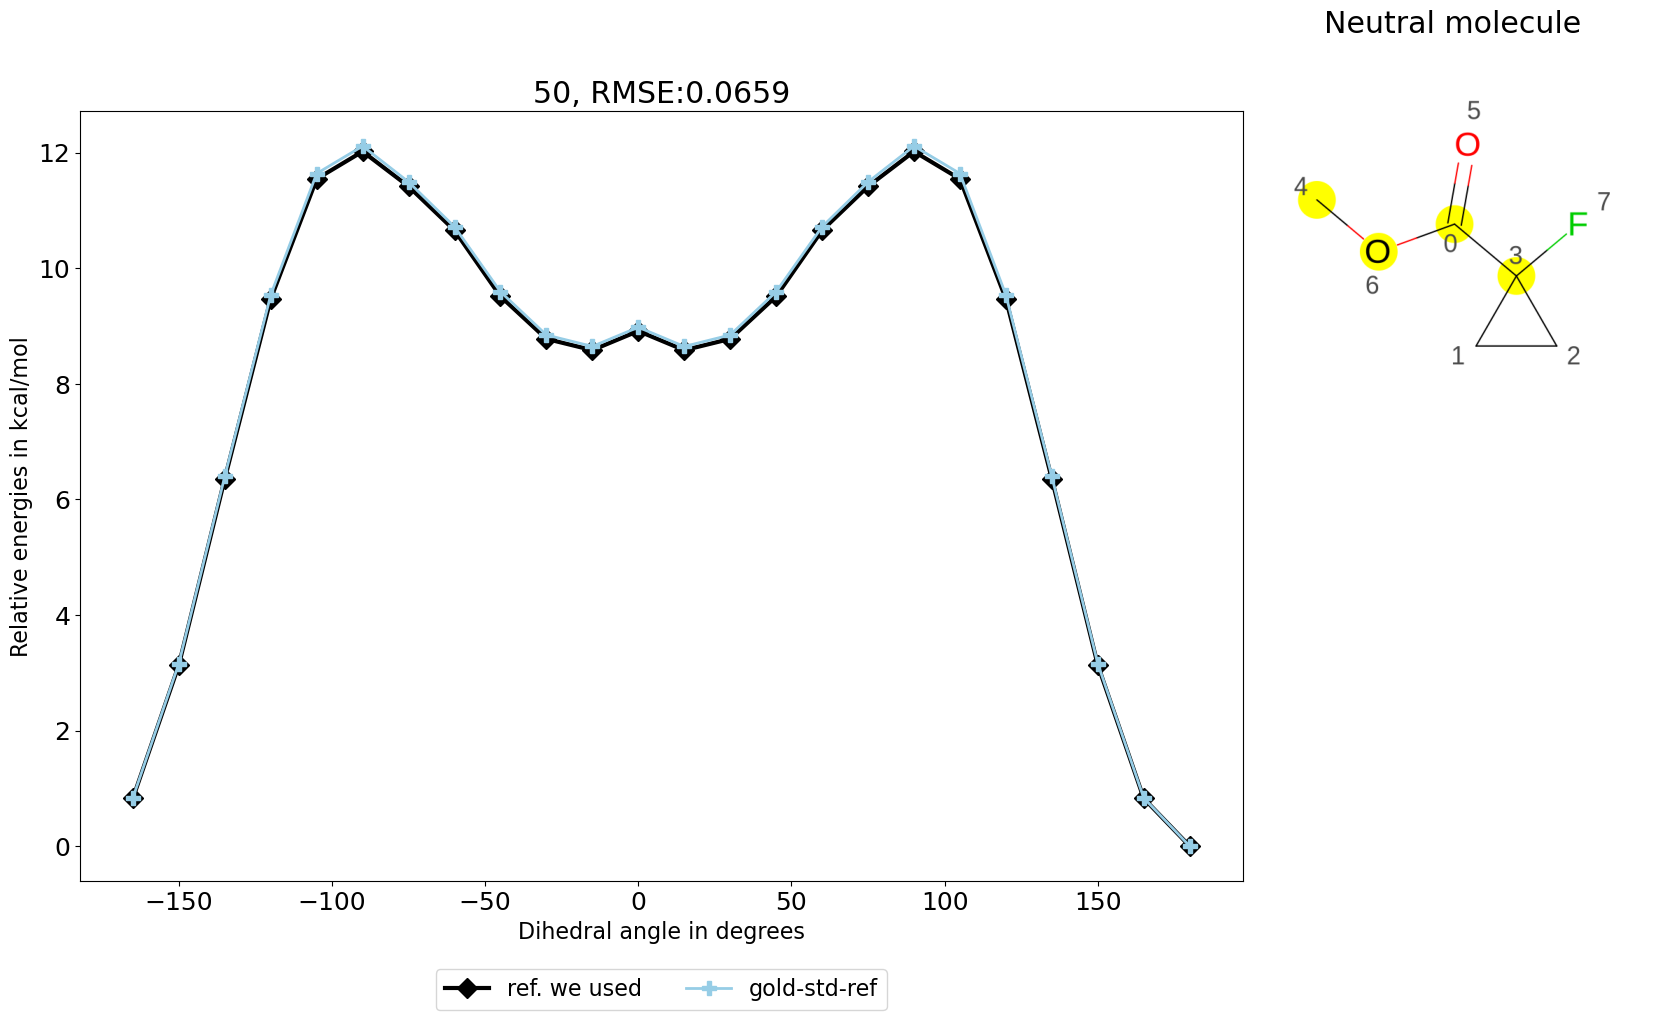

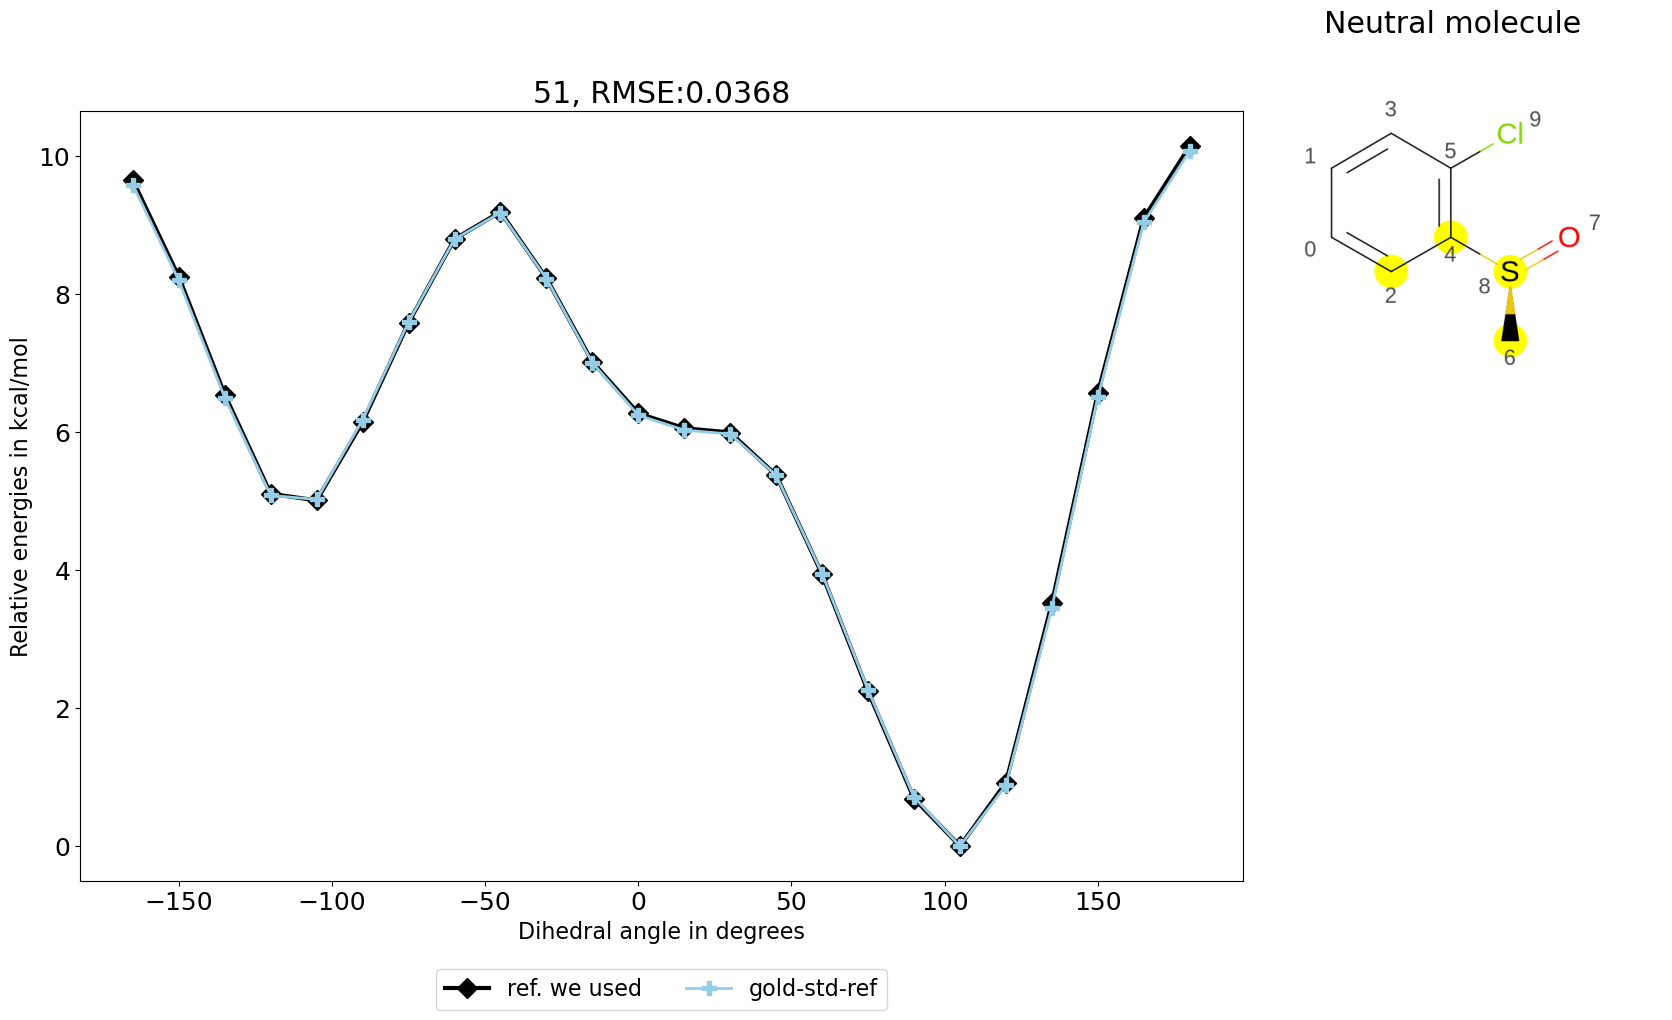

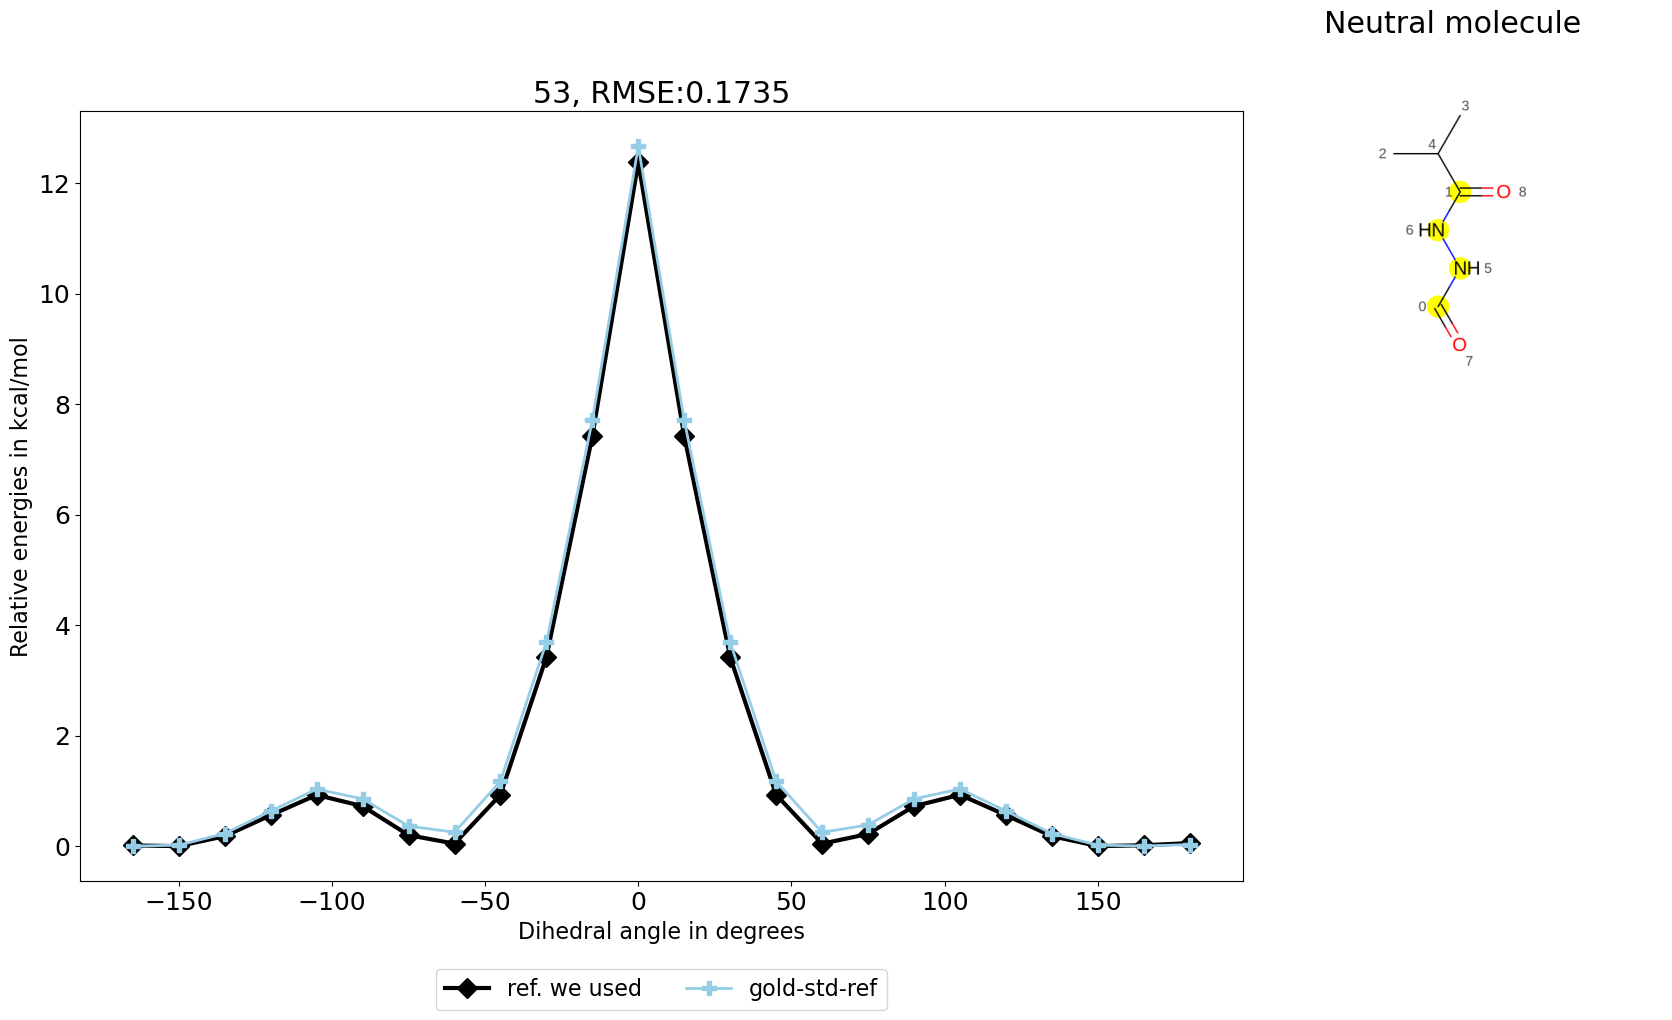

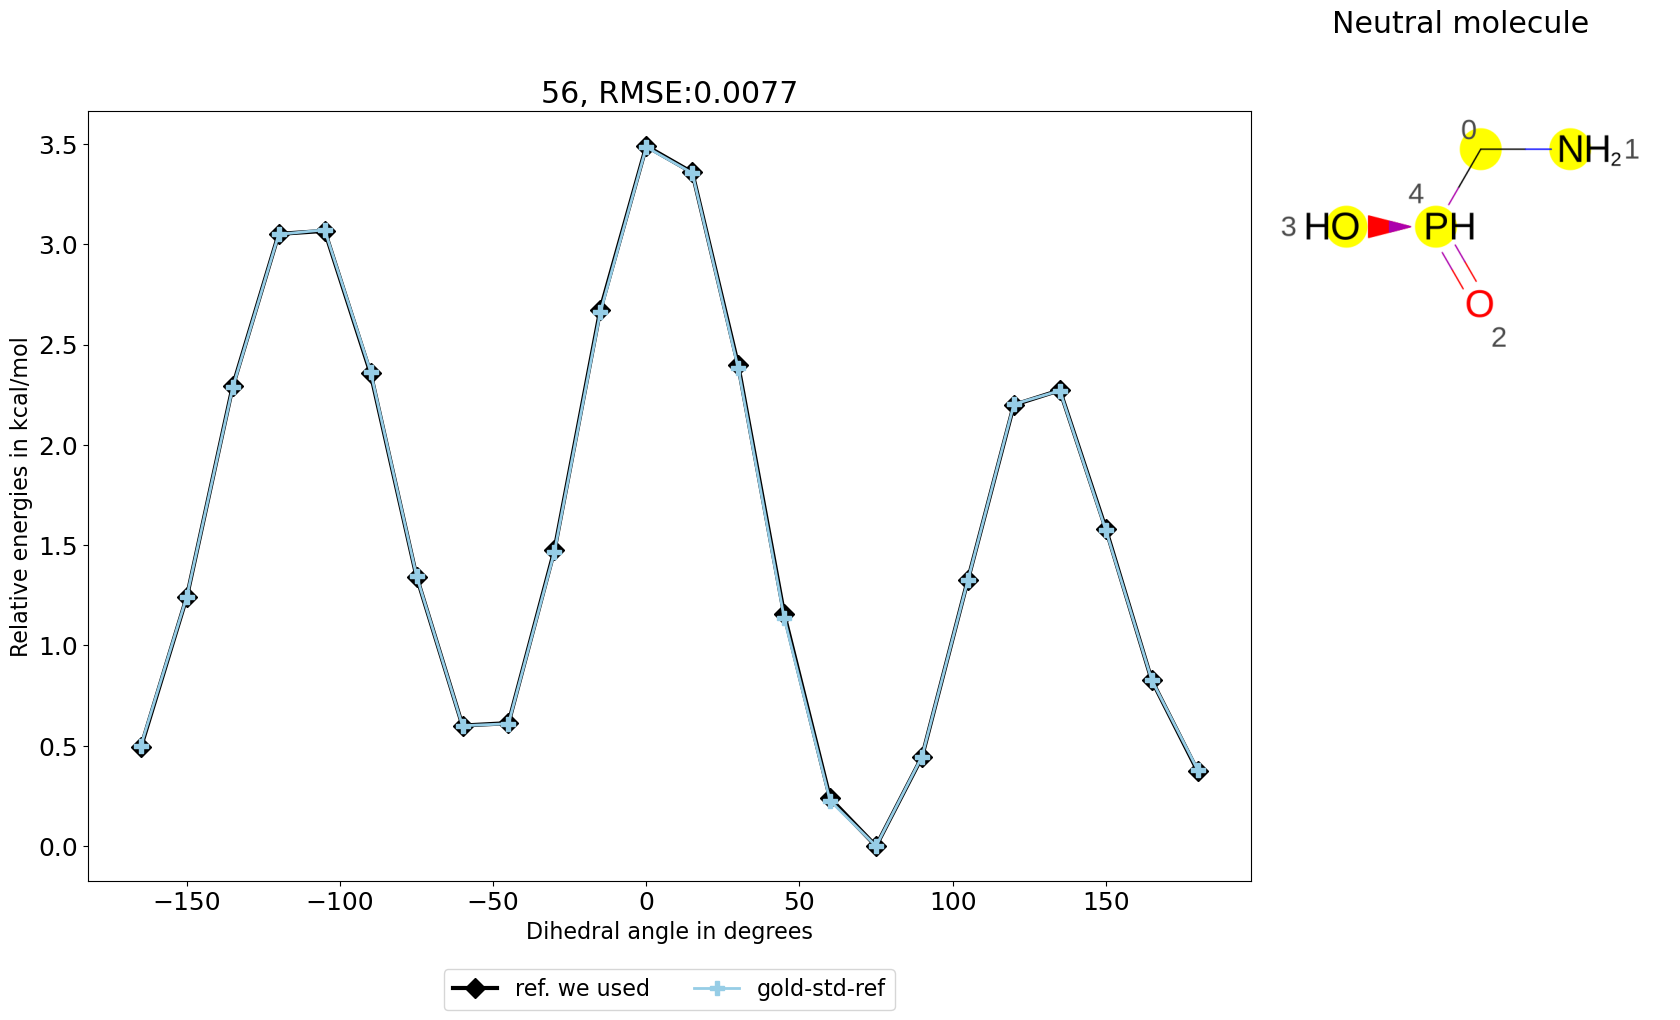

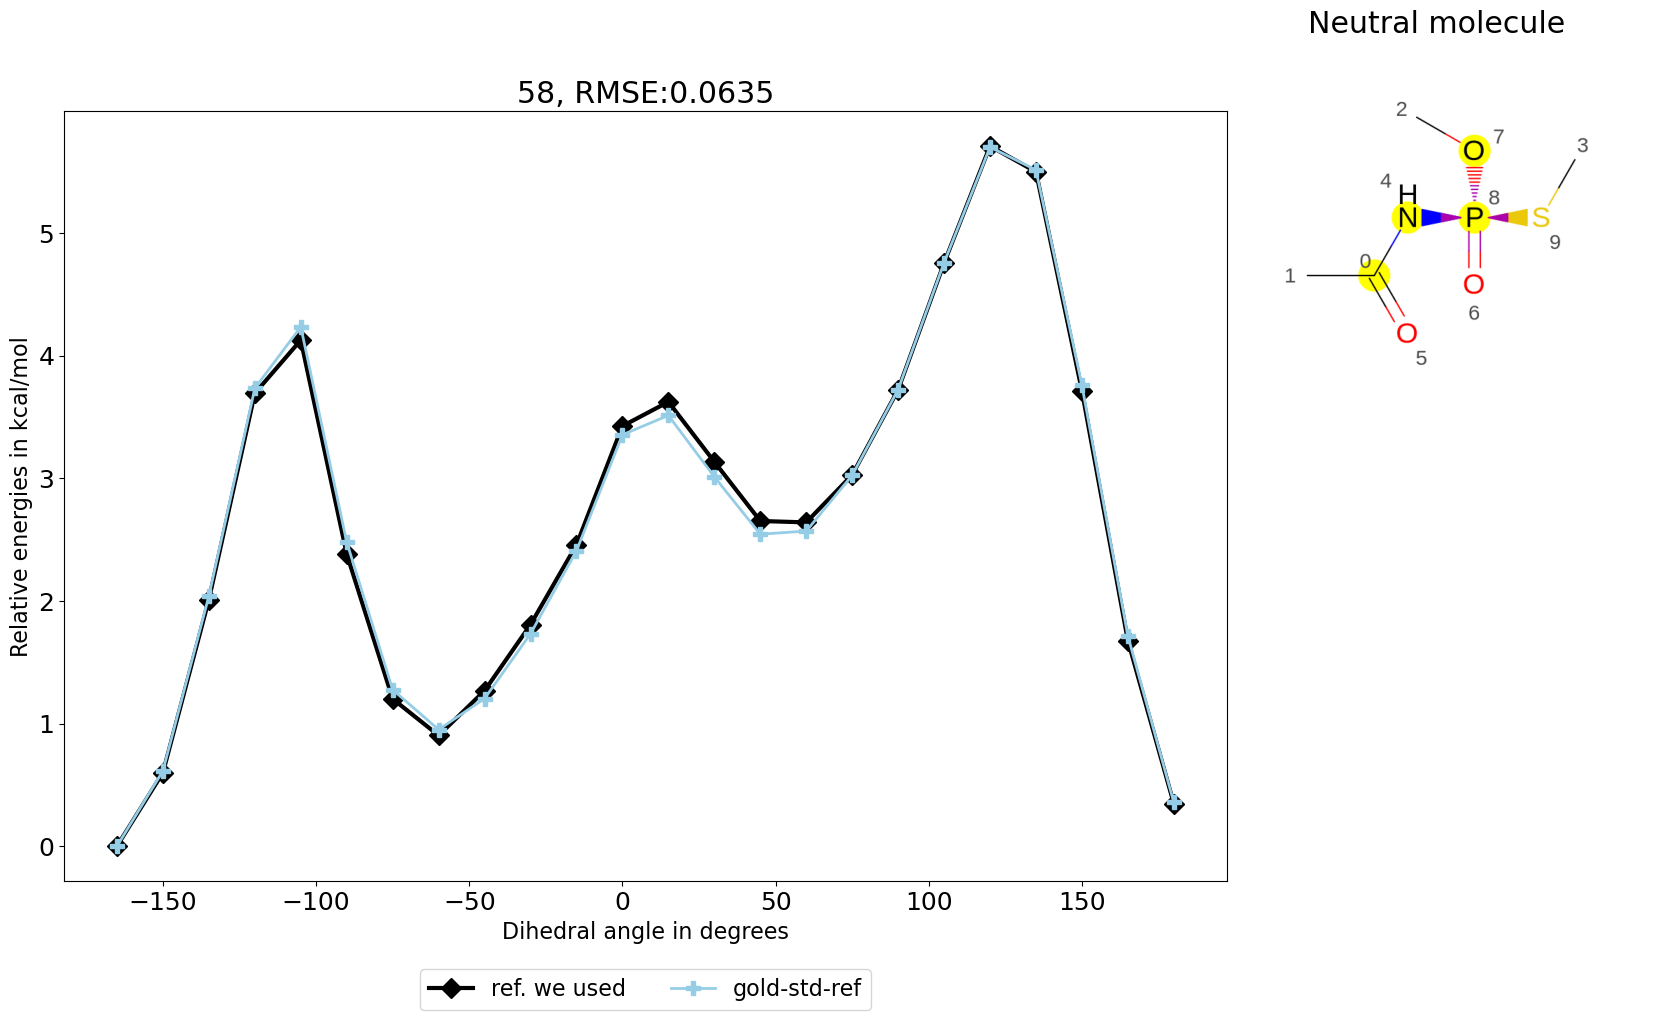

In [9]:
rmse = defaultdict(dict)
neutral_rmse = defaultdict(dict)
charged_rmse = defaultdict(dict)
mae = defaultdict(dict)
table = []
rcParams.update({"font.size": 18})
with open('./data/'+REF_SPEC.replace('/','_')+'_single_points_data.json', 'r') as file:
        ref_dict = json.load(file)
with open('./data/MP2_heavy-aug-cc-pVTZ_torsiondrive_data.json', 'r') as file:
    mp2_data = json.load(file)    
with open('./data/aug-cc-pVTZ_gold_std_single_points.json', 'r') as file:
    energies_data = json.load(file)

all_energies = defaultdict(list)
neutral_energies = defaultdict(list)
charged_energies = defaultdict(list)
neutral_ref = []
charged_ref = []
all_ref = []

for i in [25, 39, 50, 51, 53, 56, 58]:
    key='gold-std-ref'
    ref_energies = np.array(get_relative_energies(ref_dict[str(i)]['total energies'], HARTREE_TO_KCALMOL))
    ref_angles = ref_dict[str(i)]['angles']
    mapped_smiles = mp2_data[str(i)]['metadata']['mapped_smiles']
    dihedrals = mp2_data[str(i)]['metadata']['dihedral scanned'][0]
    mol_charge = mp2_data[str(i)]['metadata']['mol_charge']
    offmol = Molecule.from_mapped_smiles(mapped_smiles)
    flag_neutral = True
    if mol_charge != 0:
        flag_neutral = False
    elif mol_charge == 0  and mapped_smiles.find('+') != -1:
        flag_neutral = False
    
    all_ref.extend(ref_energies)
    if flag_neutral:
        neutral_ref.extend(ref_energies)
    else:
        charged_ref.extend(ref_energies)
        
    fig, ax = plt.subplots(figsize=[15, 10])
    ax.plot(
            ref_angles,
            ref_energies,
            "-D",
            label="ref. we used",
            linewidth=3.0,
            c="k",
            markersize=10,
        )
    
    angles = energies_data[str(i)]['angles']
    energies = np.array(get_relative_energies(energies_data[str(i)]['final_energies'], HARTREE_TO_KCALMOL))

    rmse_energies = np.sqrt(np.mean((energies - ref_energies) ** 2))
    mae_energies = np.mean(np.abs(energies - ref_energies))
    rmse[i][key] = rmse_energies
    mae[i][key] = mae_energies
    # print(i, '%.2f'%rmse_energies)
    all_energies[key].extend(energies)
    if flag_neutral:
        neutral_energies[key].extend(energies)
        neutral_rmse[i][key] = rmse_energies
    else:
        charged_energies[key].extend(energies)
        charged_rmse[i][key] = rmse_energies


    ax.plot(
            angles,
            energies,
            marker=markers[1],
            label=key,
            linewidth=2.0,
            c=KELLYS_COLORS[1 + 1],
            markersize=10,
        )
            
    
    plt.xlabel("Dihedral angle in degrees", fontsize=16)
    plt.ylabel("Relative energies in kcal/mol", fontsize=16)
    plt.title(f"{i}, RMSE:{rmse_energies:0.4f}")
    # plt.legend(loc="lower left", bbox_to_anchor=(1.04, 0), fontsize=12)
    plt.legend(loc='upper center',  bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=False, ncol=5, fontsize=16)
    oemol = offmol.to_openeye()
    image = show_oemol_struc(
        oemol, torsions=True, atom_indices=dihedrals, width=600, height=500
    )
    img = Image.open(io.BytesIO(image.data))
    im_arr = np.asarray(img)
    newax = fig.add_axes([0.9, 0.6, 0.35, 0.35], anchor="SW", zorder=-1)
    newax.imshow(im_arr)
    newax.axis("off")
    if flag_neutral:
        plt.title('Neutral molecule')
    else:
        plt.title('Charged molecule')
    plt.savefig(f'./output/{i}_torsion_profile_gold.png', dpi=300, bbox_inches="tight")   
    plt.show()
    
    pdf.savefig(fig, dpi=300, bbox_inches="tight")   


In [10]:
rmse

defaultdict(dict,
            {25: {'gold-std-ref': 0.01015746265287094},
             39: {'gold-std-ref': 0.024566794352900642},
             50: {'gold-std-ref': 0.06586447590197303},
             51: {'gold-std-ref': 0.036771806850790054},
             53: {'gold-std-ref': 0.17347813786861105},
             56: {'gold-std-ref': 0.007731389672278901},
             58: {'gold-std-ref': 0.06349960536415136}})

In [12]:
keywords_list = ['gold-std-ref']
for k, key in enumerate(keywords_list):    
    all_ref = np.array(all_ref)
    method_energies = np.array(all_energies[key])
    rmse_stats = bootstrap_statistic(y_true=all_ref, y_pred=method_energies, statistic='RMSE')
    mue_stats = bootstrap_statistic(y_true=all_ref, y_pred=method_energies, statistic='MUE')   
    table.append([key,
                  "%.4f" % rmse_stats['mle'],"%.4f" % rmse_stats['low'],"%.4f" % rmse_stats['high'],
                  "%.4f" % mue_stats['mle'],"%.4f" % mue_stats['low'],"%.4f" % mue_stats['high'],]
                  )

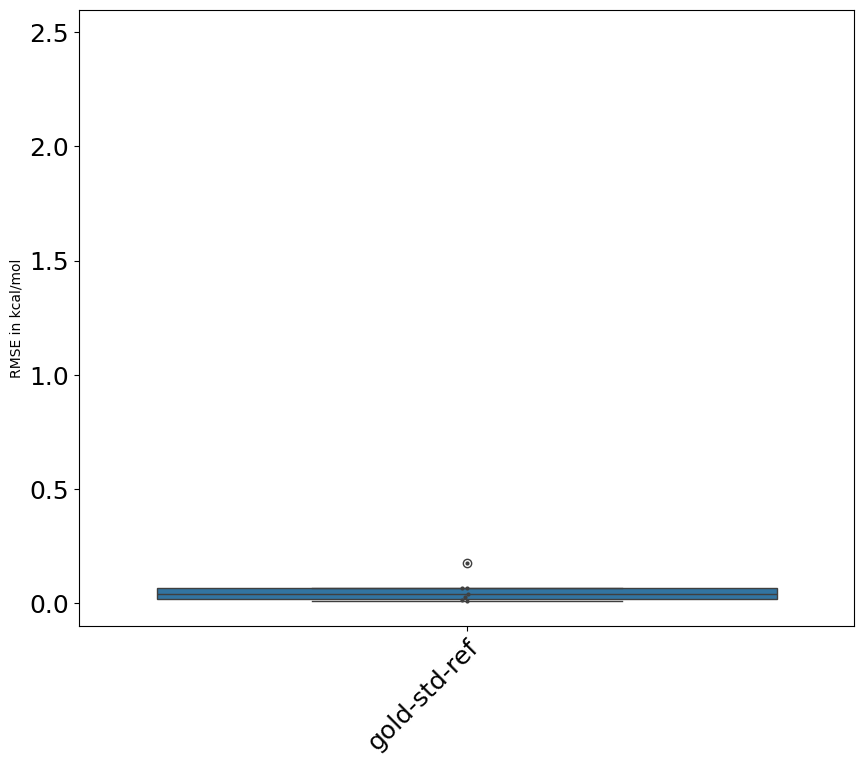

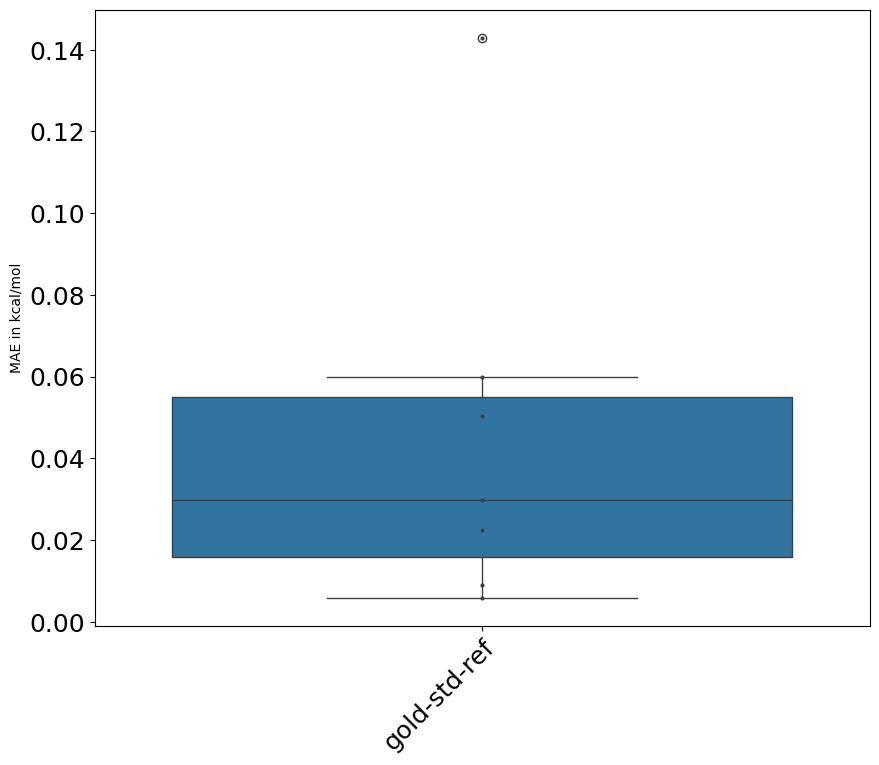

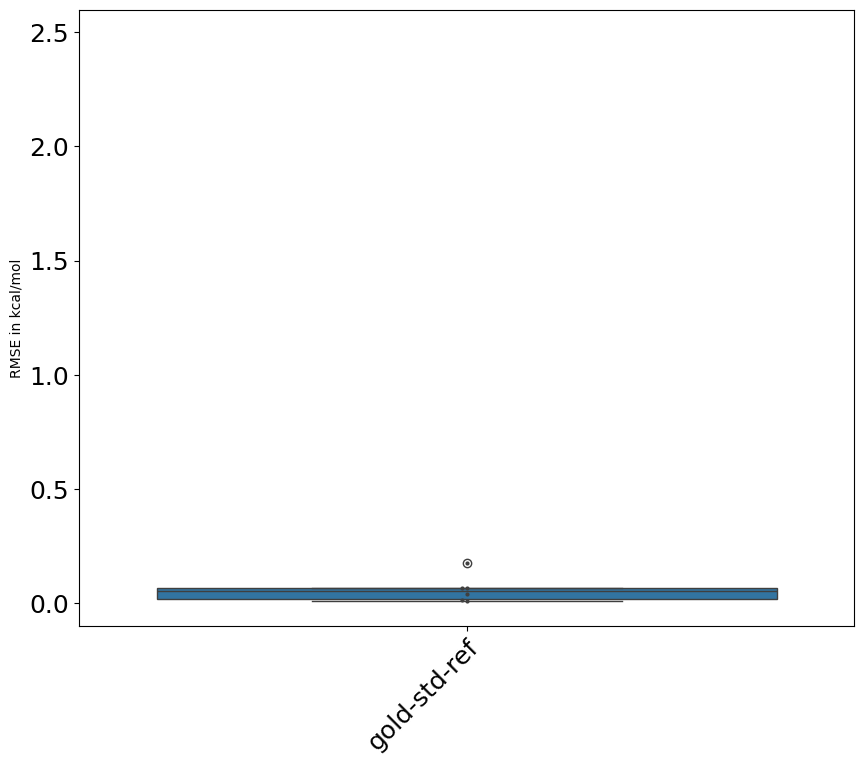

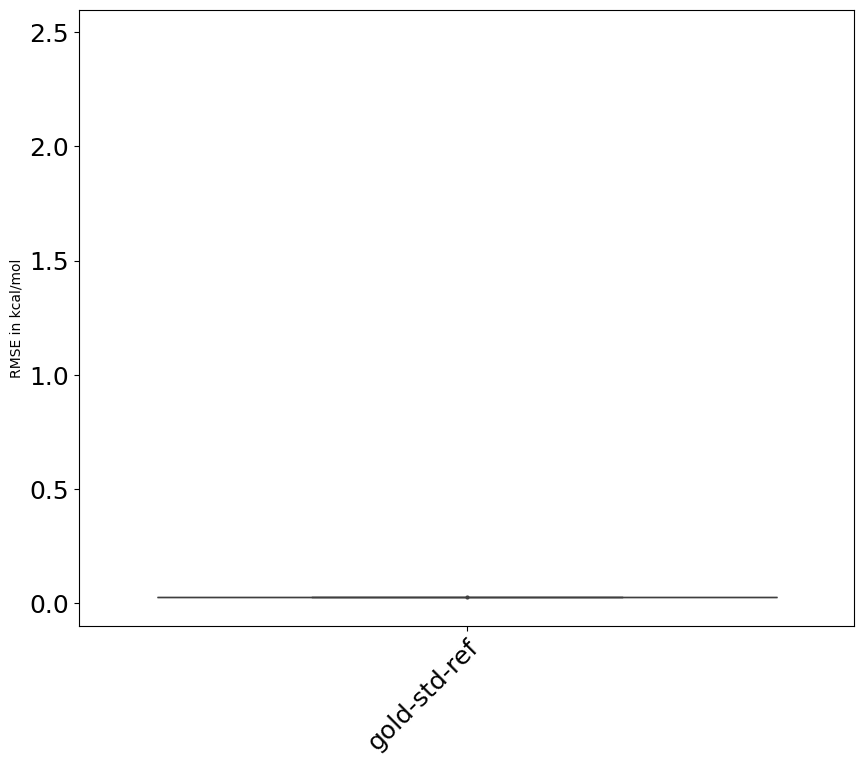

| Specification   |   RMSE in kcal/mol |   low 95% ci |   high 95% ci |   MAE in kcal/mol |   low 95% ci |   high 95% ci |
|-----------------+--------------------+--------------+---------------+-------------------+--------------+---------------|
| gold-std-ref    |             0.0761 |       0.0609 |        0.0904 |            0.0457 |       0.0369 |        0.0546 |
* closer to zero the better


In [13]:
# RMSE, MAE
fig, ax = plt.subplots(figsize=[10, 8])
# Width of a bar
width = 0.25

tmp_df = pd.DataFrame(rmse)
df = tmp_df.T
ax = sns.boxplot(data=df)
ax = sns.swarmplot(data=df, size=3, color="0.25")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.xaxis.get_label().set_fontsize(12)
ax.set(ylabel="RMSE in kcal/mol")
ax.yaxis.get_label().set_fontsize(10)
ax.set_ylim(-0.1, 2.6)
fig = ax.get_figure()
plt.savefig('./output/rmse-all-functionals.png',dpi=600,
            bbox_inches="tight")
plt.show()
pdf.savefig(fig, dpi=600, bbox_inches="tight")



fig, ax = plt.subplots(figsize=[10, 8])
# Width of a bar
width = 0.25
tmp_df = pd.DataFrame(mae)
df = tmp_df.T
ax = sns.boxplot(data=df)
ax = sns.swarmplot(data=df, size=3, color="0.25")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.xaxis.get_label().set_fontsize(12)
ax.set(ylabel="MAE in kcal/mol")
ax.yaxis.get_label().set_fontsize(10)
fig = ax.get_figure()
pdf.savefig(fig, dpi=600, bbox_inches="tight")

fig, ax = plt.subplots(figsize=[10, 8])
# Width of a bar
width = 0.25
tmp_df = pd.DataFrame(neutral_rmse)
df = tmp_df.T
ax = sns.boxplot(data=df)
ax = sns.swarmplot(data=df, size=3, color="0.25")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.xaxis.get_label().set_fontsize(12)
ax.set(ylabel="RMSE in kcal/mol")
ax.yaxis.get_label().set_fontsize(10)
ax.set_ylim(-0.1, 2.6)
fig = ax.get_figure()
plt.savefig('./output/neutral-rmse-b3lyp-and-basis.png',dpi=600,
            bbox_inches="tight")
plt.show()
pdf.savefig(fig, dpi=600, bbox_inches="tight")


fig, ax = plt.subplots(figsize=[10, 8])
# Width of a bar
width = 0.25
tmp_df = pd.DataFrame(charged_rmse)
df = tmp_df.T
ax = sns.boxplot(data=df)
ax = sns.swarmplot(data=df, size=3, color="0.25")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.xaxis.get_label().set_fontsize(12)
ax.set(ylabel="RMSE in kcal/mol")
ax.yaxis.get_label().set_fontsize(10)
ax.set_ylim(-0.1, 2.6)
fig = ax.get_figure()
plt.savefig('./output/charged-rmse-b3lyp-and-basis.png',dpi=600,
            bbox_inches="tight")
plt.show()
pdf.savefig(fig, dpi=600, bbox_inches="tight")

pdf.close()


print(
    tabulate(
        table,
        headers=["Specification", 
                 "RMSE in kcal/mol", "low 95% ci", "high 95% ci", 
                 "MAE in kcal/mol", "low 95% ci", "high 95% ci", 
                 "Neutral RMSE in kcal/mol", "low 95% ci", "high 95% ci", 
                 "Charged RMSE in kcal/mol", "low 95% ci", "high 95% ci", 
                 "lt_five_RMSE in kcal/mol", "low 95% ci", "high 95% ci"],
        tablefmt="orgtbl",
    )
)
print("* closer to zero the better")

with open("./output/rmse_scores_test.txt", "w") as f:
    f.write("Using " + REF_SPEC + " as a reference method the scores are: \n")
    f.write(
        tabulate(
            table,
            headers=["Specification", "RMSE in kcal/mol", "MAE in kcal/mol"],
            tablefmt="orgtbl",
        )
    )
    f.write("\n")
    f.write("* closer to zero the better")

In [15]:
# For latex table entries
print("RMSE MUE TRR")
for item in table:
    print(
        f"{item[0].upper()} & ${{{item[1]}}}_{{{item[2]}}}^{{{item[3]}"
        f"}}$ & ${{{item[4]}}}_{{{item[5]}}}^{{{item[6]}}}$ \\\\ \\vspace{{2mm}}")


RMSE MUE TRR
GOLD-STD-REF & ${0.0761}_{0.0609}^{0.0904}$ & ${0.0457}_{0.0369}^{0.0546}$ \\ \vspace{2mm}
